In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as pc
from scipy.optimize import minimize


In [228]:
daily=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_D_2021-2024.csv',sep=';')
daily.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
weekly=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_W_2021-2024.csv',sep=';')
weekly.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
weekend=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_WE_2021-2024.csv',sep=';')
weekend.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
monthly=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_M_2021-2024.csv',sep=';')
monthly.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
quarterly=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_Q_2021-2024.csv',sep=';')
quarterly.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
yearly=pd.read_csv('data/EEX_POWER_FUT_DE_BASE_Y_2021-2024.csv',sep=';')
yearly.drop(columns=['Price','ChangeComment','ValidationStatus'],inplace=True)
#aggregate data
forwards = pd.concat([daily,weekly,weekend,monthly,quarterly,yearly])
#drop rows where settlement is missing
forwards.dropna(subset=['Settlement'],inplace=True)
forwards['TimeStamp'] = pd.to_datetime(forwards['TimeStamp'], errors='coerce')
forwards['Begin'] = pd.to_datetime(forwards['Begin'], errors='coerce')
forwards['End'] = pd.to_datetime(forwards['End'], errors='coerce')
forwards['Settlement'] = forwards['Settlement'].str.replace(',','.').astype(float)
forwards['Open'] = forwards['Open'].str.replace(',','.').astype(float)
forwards['High'] = forwards['High'].str.replace(',','.').astype(float)
forwards['Low'] = forwards['Low'].str.replace(',','.').astype(float)
forwards['Close'] = forwards['Close'].str.replace(',','.').astype(float)
forwards['Identifier'] = forwards['Identifier'].str[22:]
forwards.sort_values(by=['TimeStamp'],inplace=True)
forwards.head()



,Identifier,TimeStamp,Begin,End,Open,High,Low,Close,Settlement
0,D,2021-01-04 00:00:00+01:00,2021-01-01 00:00:00+01:00,2021-01-02 00:00:00+01:00,NaN,NaN,NaN,NaN,48.40
5,Q,2021-01-04 00:00:00+01:00,2022-07-01 00:00:00+02:00,2022-10-01 00:00:00+02:00,NaN,NaN,NaN,NaN,48.78
4,Q,2021-01-04 00:00:00+01:00,2022-04-01 00:00:00+02:00,2022-07-01 00:00:00+02:00,NaN,NaN,NaN,NaN,46.59
3,Q,2021-01-04 00:00:00+01:00,2022-01-01 00:00:00+01:00,2022-04-01 00:00:00+02:00,54.65,54.65,54.65,54.65,54.60
2,Q,2021-01-04 00:00:00+01:00,2021-10-01 00:00:00+02:00,2022-01-01 00:00:00+01:00,52.30,52.30,52.05,52.05,51.92


In [208]:
def check_arbitrage(date, start=None, end=None):
    # Select the relevant data based on the date and make a copy
    df = forwards[(forwards['TimeStamp'].astype(str).str.contains(date)) | (forwards['TimeStamp'].astype(str) == date)].copy()
    if end : df = df[df['End'] <= pd.to_datetime(end,utc=2)]	
    if start : df = df[df['Begin'] + pd.Timedelta(hours=2) >= pd.to_datetime(start,utc=2)]
    # Convert columns to datetime and create contract length column
    df['Begin'] = pd.to_datetime(df['Begin'], utc=True)
    df['End'] = pd.to_datetime(df['End'], utc=True)
    df['contract_length_days'] = (df['End'] - df['Begin']).dt.days

    # Define possible contract pairs (short vs long term)
    pairs = [('D', 'W'), ('D', 'WE'), ('W', 'M'), ('M', 'Q'), ('Q', 'Y')]  

    arbitrage_opportunities = []

    # Iterate over each pair of contracts
    for short, long in pairs:
        # Filter contracts by Identifier
        short_contracts = df[df['Identifier'] == short]
        long_contracts = df[df['Identifier'] == long]

        # Find combinations of short contracts that combine to a long contract
        for _, long_contract in long_contracts.iterrows():
            begin = long_contract['Begin']
            end = long_contract['End']
            short_date = begin
            combination = []
            while short_date < end:
                short_contract = short_contracts[short_contracts['Begin'] == short_date]
                if short_contract.empty:
                    break
                combination.append(short_contract)
                short_date = short_contract['End'].iloc[0]
            if short_date == end:
                mean_short = np.mean([short['Settlement'].iloc[0] for short in combination])
                long_settlement = long_contract['Settlement']
                if abs(long_settlement - mean_short) > 0.01:
                    arbitrage_opportunities.append({
                        'timestamp': date,
                        'long': long,
                        'short': short,
                        'begin': begin,
                        'end': end,
                        'long_settlement': long_settlement,
                        'short_settlement': mean_short,
                        'profit': long_settlement - mean_short
                    })

    # Display arbitrage opportunities
    arbitrage_df = pd.DataFrame(arbitrage_opportunities)
    return arbitrage_df



In [203]:
def get_forwards(timestamp, start = None, end = None,  periods = ['D', 'W', 'WE', 'M', 'Q', 'Y']):
    data = forwards[((forwards['TimeStamp'].astype(str).str.contains(timestamp))|(forwards['TimeStamp'].astype(str)==timestamp))&(forwards.Identifier.isin(periods))]
    if end : data = data[data['End'] <= pd.to_datetime(end,utc=2)]	
    if start : data = data[data['Begin'] + pd.Timedelta(hours=2) >= pd.to_datetime(start,utc=2)]
    return data.sort_values(by=['Begin'])

In [227]:
#make one big dataframe with arbitrage for every timestamp
arbitrage_df = pd.DataFrame()
for date in forwards['TimeStamp'].astype(str).unique():
    arbitrage_df = pd.concat([arbitrage_df,check_arbitrage(date)])
arbitrage_df.sort_values(by=['profit'],ascending=False)

,timestamp,long,short,begin,end,long_settlement,short_settlement,profit
0,2022-03-21 00:00:00+01:00,W,D,2022-03-20 23:00:00+00:00,2022-03-27 22:00:00+00:00,213.41,213.078571,0.331429
1,2022-03-21 00:00:00+01:00,WE,D,2022-03-25 23:00:00+00:00,2022-03-27 22:00:00+00:00,170.44,170.165000,0.275000
0,2022-03-23 00:00:00+01:00,WE,D,2022-03-25 23:00:00+00:00,2022-03-27 22:00:00+00:00,173.08,172.810000,0.270000
3,2022-12-27 00:00:00+01:00,Y,Q,2022-12-31 23:00:00+00:00,2023-12-31 23:00:00+00:00,244.43,244.185000,0.245000
3,2022-12-28 00:00:00+01:00,Y,Q,2022-12-31 23:00:00+00:00,2023-12-31 23:00:00+00:00,238.85,238.605000,0.245000
...,...,...,...,...,...,...,...,...
0,2022-08-25 00:00:00+02:00,Q,M,2022-12-31 23:00:00+00:00,2023-03-31 22:00:00+00:00,936.02,938.420000,-2.400000
2,2022-09-06 00:00:00+02:00,Q,M,2022-12-31 23:00:00+00:00,2023-03-31 22:00:00+00:00,795.00,797.453333,-2.453333
0,2022-08-29 00:00:00+02:00,Q,M,2022-12-31 23:00:00+00:00,2023-03-31 22:00:00+00:00,979.31,981.890000,-2.580000
1,2022-09-05 00:00:00+02:00,Q,M,2022-12-31 23:00:00+00:00,2023-03-31 22:00:00+00:00,860.09,863.003333,-2.913333


In [133]:
def plot_forecast_forwards(timestamp, forecast):
    data = get_forwards(timestamp,start = forecast['timestamp'].min(), end = forecast['timestamp'].max(), periods=['D', 'W', 'WE', 'M', 'Q', 'Y'])
    fig = go.Figure()
    unique_identifiers = data['Identifier'].unique()
    color_map = {identifier: color for identifier, color in zip(unique_identifiers, pc.qualitative.Plotly)}
    added_identifiers = set()
    # Add the forecast trace
    fig.add_trace(go.Scatter(
        x=forecast['timestamp'],
        y=forecast['yhat'],
        mode='lines',
        name='forecast',
        line=dict(color='black')  
    ))
    #add the forwards
    for index, row in data.iterrows():
        show_legend = row['Identifier'] not in added_identifiers
        fig.add_trace(go.Scatter(
            x=[row['Begin'], row['End']],
            y=[row['Settlement'], row['Settlement']],
            mode='lines',
            name=row['Identifier'] if show_legend else None,
            showlegend=show_legend,
            line=dict(color=color_map[row['Identifier']])
        ))
        added_identifiers.add(row['Identifier'])
    fig.show()
    
    

In [181]:
#create linear constraints that guarant arbitrage freeness for an hourly price curve
def get_restrictions(timestamp, start_date,end_date):
    length = ((pd.to_datetime(end_date,utc=2) - pd.to_datetime(start_date,utc=2)).days + 1)* 24
    contracts  = get_forwards(timestamp,start = start_date, end = end_date)
    mult = {'D': 24, 'W': 24*7, 'WE': 24*2, 'M': 24*30, 'Q': 24*90, 'Y': 24*365}
    s = contracts['Settlement'].values
    d = len(s)
    C = np.zeros((d,length))
    for i in range(d):
        start_contract = contracts.iloc[i].Begin 
        end_contract = contracts.iloc[i].End
        start_index = (start_contract - pd.to_datetime(start_date,utc=2)+pd.Timedelta(hours=1)).days*24
        end_index = (end_contract - pd.to_datetime(start_date,utc=2)+pd.Timedelta(hours=1)).days*24
        C[i,start_index:end_index] = 1
        s[i] = s[i]*mult[contracts.iloc[i].Identifier]
    return C, s

In [222]:
def arbitrage_correction(timestamp, forecast, lambda_1=0):
    start = forecast['timestamp'].min()
    end = forecast['timestamp'].max()
    #plot before correction
    plot_forecast_forwards(timestamp, forecast)
    #check for arbitrage in forwards
    arbitrage_df = check_arbitrage(timestamp, start, end)
    if not arbitrage_df.empty:
        print(f"Arbitrage opportunities found: {arbitrage_df}")
    else:
        print("No arbitrage opportunities found in forwards")
    #optimize forecast
    yhat = np.array(test_forecast['yhat'].values)
    x0 = yhat

    def objective_function(x):
        return np.sum(np.square(x-yhat)) + lambda_1*np.sum(np.square(np.diff(x)))

    A_eq, b_eq = get_restrictions(timestamp, start, end)
    
    result = minimize(objective_function, x0, method ='trust-constr', constraints={'type':'eq','fun': lambda x: A_eq@x - b_eq})

    if result.success:
        print("Optimum found")
        plot_forecast_forwards(timestamp, pd.DataFrame({'timestamp': forecast['timestamp'], 'yhat': result.x}))
        return result.x, arbitrage_df
    else:
        print("Optimization failed:", result.message)
        plot_forecast_forwards(timestamp, pd.DataFrame({'timestamp': forecast['timestamp'], 'yhat': result.x}))
        return yhat, arbitrage_df

In [225]:
test_forecast= pd.read_csv('data/test_forecast_medium.csv',sep=',')
test_forecast['timestamp'] = pd.to_datetime(test_forecast['ds'], errors='coerce')
arbitrage_correction('2021-01-04',test_forecast,lambda_1 = 0)

No arbitrage opportunities found in forwards
Optimum found


(array([35.1673192 , 33.41911218, 31.37415721, 29.9849098 , 30.78111761,
        34.38287032, 39.78405789, 45.01751461, 47.0512521 , 46.76388986,
        44.64539009, 42.29866372, 39.6054688 , 38.25095624, 37.54653245,
        38.62018014, 41.41109627, 45.53202495, 49.09899112, 50.04973658,
        47.9202646 , 43.27928853, 38.63497176, 35.37316357, 47.57729307,
        45.45194616, 42.8765771 , 41.27911275, 41.52403277, 44.84566762,
        49.79148901, 54.21282155, 56.13331885, 55.42858775, 52.49516777,
        49.57486188, 46.79459873, 44.77561647, 43.719952  , 44.28579569,
        46.74886792, 50.67035373, 53.84162153, 54.54301445, 52.16689425,
        47.37089987, 42.59248292, 39.53635866, 29.26130425, 27.52215343,
        24.7090895 , 23.69819604, 24.00587953, 27.66929023, 33.4132702 ,
        38.32885884, 40.92095469, 40.54155625, 38.42729833, 36.51462355,
        34.19713053, 33.1059944 , 32.78037957, 34.55570568, 37.53217231,
        42.66752794, 46.71208746, 48.48792617, 46.8

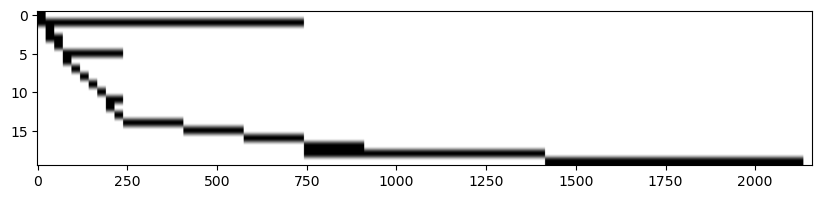

In [226]:
#visualize constraints
start = test_forecast['timestamp'].min()
end = test_forecast['timestamp'].max()
timestamp = '2021-01-04'
A, b= get_restrictions(timestamp,start,end)
plt.figure(figsize=(10, 2))  # Adjust the figure size for better readability
plt.imshow(A, cmap='binary', aspect='auto')  # 'auto' aspect ratio scales with the matrix shape
plt.show()